In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import norm
import emcee
import pandas as pd
from tqdm import trange
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import logsumexp, erf
from scipy.optimize import minimize
from scipy import stats
from scipy.integrate import cumtrapz, quad
import pystan

# matplotlib set-up
columnwidth = 20 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                                'backend': 'pdf',
                                'font.size': 14,
                                'legend.fontsize': 14,
                                'legend.frameon': False,
                                'legend.loc': 'best',
                                'lines.markersize': 3,
                                'lines.linewidth': 2,
                                'axes.linewidth': .5,
                                'axes.edgecolor': 'black'})

Stan model

In [2]:
model_code = """
data {
    int num_CC_obs;  // Number of direct observations of the inverse.
    vector[num_CC_obs] hz_CC_obs;  // CC H(z)
    vector[num_CC_obs] hz_CC_sigma;  // CC noise
    int z_CC_ind[num_CC_obs]; // GP node indices of CC redshifts 
    
    int num_SN_obs;  // Number of SN observations.
    vector[num_SN_obs] z_SN;  // SN redshifts
    vector[num_SN_obs] mu_SN_obs;  // SN obs
    matrix[num_SN_obs, num_SN_obs] L_SN;  // Supernovae covariance (Cholesky)
    int z_SN_ind[num_SN_obs]; // GP node indices of SN redshifts
    
    int num_z;  // Number of redshfit nodes for GP
    vector[num_z] z; // Redshift nodes for GP
    matrix[num_z, num_z] d2; // Square distances for the GP nodes
    vector[num_z] mu; // GP mean
    matrix[num_z, num_z] epsilon;  // Small value to add to the diagonal of the covariance matrix.
    
    real<lower=0> A_upper_limit; // Upper limit on kernel amplitude
    real<lower=0> l_upper_limit; // Upper limit on kernel length-scale
}


parameters {
    real omegaK; // OmegaK
    real M; // SN calibration 
    real<lower=0> A;  // Scale of the Gaussian process.
    real<lower=0> l;  // Correlation length of the Gaussian process.
    vector[num_z] n;  // Whitened variables for the Gaussian process.
}

transformed parameters {
    matrix[num_z, num_z] K;  // Covariance for the Gaussian process.
    matrix[num_z, num_z] L;  // Cholesky decomposition
    vector[num_z] hz;  // Gaussian process
    vector[num_z] dc;  // Intgrated values of the Gaussian process.
    vector[num_CC_obs] hz_CC;  // Inverse values of the Gaussian process.
    vector[num_SN_obs] dc_SN;  // Intgrated values of the Gaussian process at SN redshifts.
    vector[num_SN_obs] mu_SN;  // Intgrated values of the Gaussian process.
    
    // Kernel
    K = A ^ 2 * exp(- d2 / (2 * l ^ 2)) + epsilon;
    
    // Evaluate the observations.
    L = cholesky_decompose(K);
    hz = L * n + mu;
    
    // compute the distances at the SN redshifts...
    dc[1] = 0; // first distance = 0
    for (i in 2:num_z) {
        dc[i] = dc[i-1] + hz[1] * (1./hz[i] + 1./hz[i-1])*(z[i] - z[i-1])/2.;  // trapezium rule      
    }
    
    // pull out the distances at the SN redshifts
    for (i in 1:num_SN_obs){
        dc_SN[i] = dc[z_SN_ind[i]];
    }
    
    // pull out the H(z)s for the CC data
    for (i in 1:num_CC_obs) {
        hz_CC[i] = hz[z_CC_ind[i]];
    }
    
    // distance moduli for the SN
    mu_SN = 5*log10((1. + z_SN) .* (sin(sqrt(fabs(omegaK)) * dc_SN) * (omegaK > 0) + sinh(sqrt(fabs(omegaK)) * dc_SN) * (omegaK < 0))/sqrt(fabs(omegaK))) - 5*log10(hz_CC[1]) + M;
}

model {
    A ~ uniform(0, A_upper_limit);
    l ~ uniform(0, l_upper_limit);
    n ~ normal(0, 1);
    hz_CC_obs ~ normal(hz_CC, hz_CC_sigma);
    mu_SN_obs ~ multi_normal_cholesky(mu_SN, L_SN);
}
"""

Compile model

In [3]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0e7049ce8e9d2391ea2a5f0fdfda9d68 NOW.


Load data

In [4]:
# SN data
mu_SN = pd.read_csv('lcparam_DS17f.txt', delim_whitespace=True, header=None, names=['mb'], usecols=(4,), skiprows=1).mb.values
mu_SN_sigma = pd.read_csv('lcparam_DS17f.txt', delim_whitespace=True, header=None, names=['dmb'], usecols=(5,), skiprows=1).dmb.values
z_SN = pd.read_csv('lcparam_DS17f.txt', delim_whitespace=True, header=None, names=['zcmb'], usecols=(1,), skiprows=1).zcmb.values
C_SN = np.genfromtxt('syscov_panth.txt') + np.diag(mu_SN_sigma**2)

# CC data
z_CC, hz_CC, hz_CC_sigma = np.loadtxt('cc_HZ_data_comp.txt', unpack = True, usecols=(0,1,2))
N_CC = np.diag(hz_CC_sigma**2)

# augment the CC data with a value for H0
z_CC = np.concatenate([np.array([0.]), z_CC])
hz_CC = np.concatenate([np.array([70.]), hz_CC])
hz_CC_sigma = np.concatenate([np.array([100.]), hz_CC_sigma])

Fit a GP to the LCDM solution, just for initializing the hyper-parameters

100%|██████████| 200/200 [00:06<00:00, 30.39it/s]


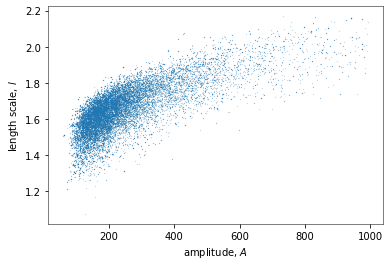

In [5]:
# compute fiducial LCDM H(z) on a redshift grid
z = np.linspace(0, 2, 40)
d2 = cdist(np.atleast_2d(z).T, np.atleast_2d(z).T)**2
omegaM = 0.3
H0 = 68
gp_mean_ = 100.
gp_mean = lambda x: gp_mean_ + x*0.
hz = H0*np.sqrt((1.-omegaM) + omegaM*(1+z)**3)

# marginal posterior for the hyper-parameters
def log_posterior_hyperparameters(theta, upper):
    
    A = theta[0]
    l = theta[1]
    l2 = theta[1]**2
    
    if A > upper[0] or np.sqrt(l2) > upper[1] or A <= 0 or l <= 0:
        return -np.inf
    else:
        K = (A**2)*np.exp(-0.5*d2/l2) + 1e-8*np.eye(len(d2))
        K_inv = np.linalg.inv(K)
        _, logdetK = np.linalg.slogdet(K)

        log_target = -0.5*np.dot(hz - gp_mean(z), np.dot(K_inv, hz - gp_mean(z))) - 0.5*logdetK

        if np.isnan(log_target):
            return -np.inf
        else:
            return log_target
        
# run the sampling
nparameters = 2
nwalkers = 200
nsteps = 200
walkers = np.array([40, 3]) + np.random.uniform(-0.05, 0.05, (nwalkers, 2))
upper = np.array([1000, 20.])
sampler = emcee.EnsembleSampler(nwalkers, nparameters, log_posterior_hyperparameters, args=[upper])
result = sampler.run_mcmc(walkers, nsteps, progress=True)
samples = sampler.chain[:,100:,:].reshape(-1, nparameters)

# plot the samples (check nothing crazy happened)
plt.scatter(samples[:,0], samples[:,1], s = 0.01)
plt.xlabel('amplitude, $A$')
plt.ylabel('length scale, $l$')
plt.show()

# set initial kernel hyper-parameters to the medians found here
A = np.median(samples[:,0])
ell = np.median(samples[:,1])

Initialization for the HMC sampler (NB: initialize at rough kLCDM best fit)

In [6]:
# redshift grid for the (latent) Gaussian process
n_between = 3 # how many redshift grid points to have in between each SN redshift (for computing the trapz integrals)?
z = np.concatenate([np.concatenate([np.linspace(0, z_SN[0], n_between + 1)] + [np.linspace(z_SN[i], z_SN[i+1], n_between + 1)[1:] for i in range(0, len(z_SN)-1)]), z_CC])
z = np.sort(np.unique(z))

# which indices of the redshift grid correspond to the SN and CC redshifts respectively (NB: +1 due to stan indices starting at 1)
z_SN_ind = [np.where(z == z_SN[i])[0][0] + 1 for i in range(len(z_SN))]
z_CC_ind = [np.where(z == z_CC[i])[0][0] + 1 for i in range(len(z_CC))]

# square distances for the redshift grid (for the GP kernel)
d2 = cdist(np.atleast_2d(z).T, np.atleast_2d(z).T)**2

# initialize kernel
epsilon = np.eye(len(z)) * 1e-5
K = A**2 * np.exp(-0.5 * d2 / ell**2) + epsilon
L = np.linalg.cholesky(K)
Linv = np.linalg.inv(L)

# fiducial parameters
omegaK = 1e-2
omegaM = 0.28
H0 = 68.
M = 32.975
H = lambda z: H0*np.sqrt(1. - omegaM + omegaM*(1+z)**3)
hz = H(z)

# initial innovation vector
n = np.dot(Linv, hz - gp_mean(z))

Inputs for the HMC sampler

In [7]:
# data
data = { # CC data
       "num_CC_obs":len(hz_CC),
       "hz_CC_obs":hz_CC,
       "z_CC_ind":z_CC_ind,
       "hz_CC_sigma":hz_CC_sigma,

       # SN data
       "num_SN_obs":40,
       "z_SN_ind":z_SN_ind,
       "z_SN":z_SN,
       "mu_SN_obs":mu_SN,
       "L_SN":np.linalg.cholesky(C_SN),
       
       # Redshift grid and GP set-up
       "z":z,
       "num_z":len(z),
       "epsilon":1e-5*np.eye(len(z)),
       "mu":gp_mean(z),
       "d2":d2,
    
       # prior limits on kernel parameters
       "A_upper_limit":700,
       "l_upper_limit":20
}

# initial parameter values
init = {"n":n,
       "omegaK":omegaK,
       "M":M,
       "A":A,
       "l":ell}

Fit the model

In [8]:
fit = model.sampling(data=data, init=[init], warmup=300, iter=800, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Plot the resulting constraints

-0.038967679170855904 0.25681071704968056


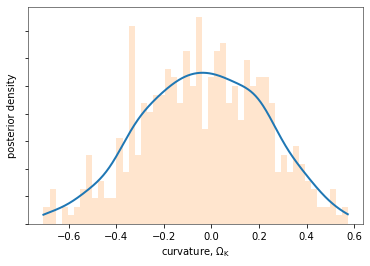

In [10]:
omegaK = fit['omegaK']
x = np.linspace(min(omegaK), max(omegaK), 500)
y = stats.gaussian_kde(omegaK)(x)
plt.plot(x, y)
plt.hist(omegaK, bins=50, alpha=0.2, density=True)
plt.xlabel(r'curvature, $\Omega_\mathrm{K}$')
ax = plt.gca()
ax.yaxis.set_ticklabels([])
print(np.median(omegaK), np.std(omegaK))
plt.ylabel('posterior density')
plt.show()

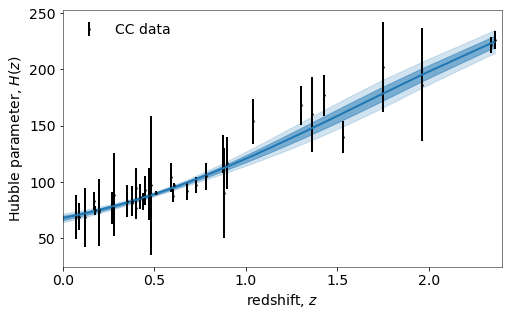

In [27]:
line, = plt.plot(z, np.mean(fit["hz"], axis=0))
plt.fill_between(z, np.mean(fit["hz"], axis=0) - 2*np.std(fit["hz"], axis=0), np.mean(fit["hz"], axis=0) + 2*np.std(fit["hz"], axis=0), alpha = 0.2, color = line.get_color())
plt.fill_between(z, np.mean(fit["hz"], axis=0) - np.std(fit["hz"], axis=0), np.mean(fit["hz"], axis=0) + np.std(fit["hz"], axis=0), alpha = 0.5, color = line.get_color())
plt.errorbar(z_CC[1:], hz_CC[1:], yerr=hz_CC_sigma[1:], fmt='.k', label='CC data')
plt.ylabel('Hubble parameter, $H(z)$')
plt.xlabel('redshift, $z$')
plt.legend()
plt.xlim(0, 2.4)
plt.show()

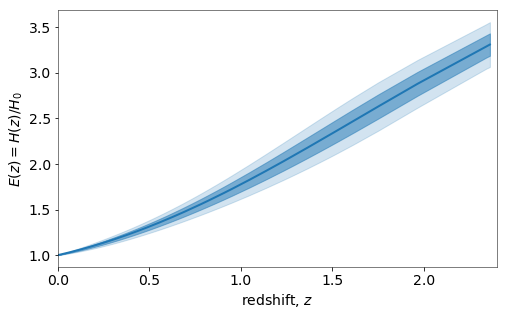

In [28]:
hz = fit["hz"]
ez = np.row_stack([hz[i,:] / hz[i,0] for i in range(len(hz))])
line, = plt.plot(z, np.mean(ez, axis=0))
plt.fill_between(z, np.mean(ez, axis=0) - 2*np.std(ez, axis=0), np.mean(ez, axis=0) + 2*np.std(ez, axis=0), alpha = 0.2, color = line.get_color())
plt.fill_between(z, np.mean(ez, axis=0) - np.std(ez, axis=0), np.mean(ez, axis=0) + np.std(ez, axis=0), alpha = 0.5, color = line.get_color())
plt.ylabel('$E(z) = H(z)/H_0$')
plt.xlabel('redshift, $z$')
plt.xlim(0, 2.4)
plt.show()
plt.show()

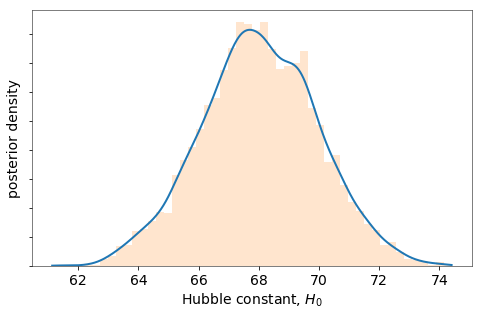

In [29]:
H0 = fit['hz'][:,0]
x = np.linspace(min(H0), max(H0), 500)
y = stats.gaussian_kde(H0)(x)
plt.plot(x, y)
plt.hist(H0, bins=50, alpha=0.2, density=True)
plt.xlabel(r'Hubble constant, $H_0$')
ax = plt.gca()
ax.yaxis.set_ticklabels([])
plt.ylabel('posterior density')
plt.show()